In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.fft
import torch.nn as nn
import torch.nn.functional as F

import torchkbnufft as tkbn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
# import pandas as pd
from glob import glob
from skimage import io, img_as_float
from skimage.metrics import mean_squared_error

# from utils import c2r

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


In [ ]:
def compute_image_nrmse(img_ref, img_pred, normalisation: str = 'range') -> float:
    # 1. Convert inputs to floating point arrays in [0,1] or [0,255] → float64.
    #    If they are integer images (e.g. uint8), convert via img_as_float to range [0,1].
    #    If already float but in 0..255, you may want to normalise manually.
    img_ref_f = img_as_float(img_ref)   # ensures dtype=float64, scaled to [0,1] for typical image dtypes
    img_pred_f = img_as_float(img_pred)

    # 2. Ensure shapes match
    if img_ref_f.shape != img_pred_f.shape:
        raise ValueError(f"Shape mismatch: img_ref shape {img_ref_f.shape} vs img_pred shape {img_pred_f.shape}")

    # 3. Compute MSE (using scikit-image's mean_squared_error, which handles arbitrary shapes)
    mse_value = mean_squared_error(img_ref_f, img_pred_f)
    rmse_value = np.sqrt(mse_value)

    # 4. Choose denominator based on desired normalisation
    if normalisation == 'range':
        ref_min = np.min(img_ref_f)
        ref_max = np.max(img_ref_f)
        denom = ref_max - ref_min
        if denom == 0:
            raise ValueError("Cannot normalise by range: reference image has zero dynamic range.")
    elif normalisation == 'mean':
        ref_mean = np.mean(img_ref_f)
        if ref_mean == 0:
            raise ValueError("Cannot normalise by mean: reference image mean is zero.")
        denom = ref_mean
    elif normalisation == 'std':
        ref_std = np.std(img_ref_f)
        if ref_std == 0:
            raise ValueError("Cannot normalise by std: reference image has zero standard deviation.")
        denom = ref_std
    else:
        raise ValueError("Unsupported normalisation type. Choose 'range', 'mean' or 'std'.")

    # 5. Compute NRMSE
    nrmse_value = rmse_value / denom
    return nrmse_value

# Dataloader

In [3]:
class modl_dataset(Dataset):
    def __init__(self, dataset_path, n_bins = 2, min_freq = -5, max_freq = 5):
        self.dataset_path = dataset_path
        self.freq_bins = np.linspace(min_freq, max_freq, num= n_bins)

    def __getitem__(self, index):
        # t1 = time.time()
        zipped_imgs = np.load(sorted(glob(f"./{self.dataset_path}/imgs*"))[index])
        gt = zipped_imgs['composite']
        freq_map = zipped_imgs['freq_map']
        binned_imgs = zipped_imgs['binned_imgs']
        # print(self.freq_bins)
        x0, kdata_sum = app_traj(binned_imgs,  self.freq_bins)
        gt_torch = torch.from_numpy(gt).to(dtype= torch.cfloat)
        A_img = torch.fft.ifftshift(kdata_sum)
        A_img = torch.fft.ifft2(A_img)
        x = torch.from_numpy(binned_imgs).to(dtype= torch.cfloat)
        # print(time.time()-t1)
        return c2r(x0), c2r(gt_torch), c2r(x.permute(-1,0,1)),A_img, freq_map

    def __len__(self):
        num_data=len(glob(f"./{self.dataset_path}/imgs*"))
        return num_data
    
def app_traj(binned_imgs,  freq_bins):
    # Prepare freq modulation
    x = np.linspace(-1, 1, binned_imgs[...,0].shape[1])
    y = np.linspace(-1, 1, binned_imgs[...,0].shape[0])
    X, Y = np.meshgrid(x, y)
    # Compute the radial distance from the centre for each point.
    R = np.sqrt(X**2 + Y**2)
    R_norm = torch.tensor(R / np.max(R)) # acts as time component
    t_r0= 5e-3
    kdata_sum = torch.zeros((binned_imgs[...,0].shape[0], binned_imgs[...,0].shape[1]), dtype= torch.cdouble)
    # fft
    for i in range(len(freq_bins)):
        
        I_loop = torch.tensor(binned_imgs[...,i],dtype=torch.cdouble)
    
        kdata = torch.fft.fft2(I_loop, norm='ortho') # convert into k-space 
        centred_kspace= torch.fft.fftshift(kdata)
        M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
        # print(M_delta_fi)
        kspace_modulated = centred_kspace * M_delta_fi
        kdata_sum += kspace_modulated

    #inverse forward model 
    Ah_y = torch.zeros((len(freq_bins),binned_imgs[...,0].shape[0], binned_imgs[...,0].shape[1]), dtype= torch.cdouble)
    for i in range(len(freq_bins)):
        M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
        kspace_inv = kdata_sum * M_delta_fi_conj
        distorted_img = torch.fft.ifftshift(kspace_inv)
        distorted_img = torch.fft.ifft2(distorted_img, norm="ortho")
        Ah_y[i] = distorted_img

    
    return Ah_y, kdata_sum
        
   

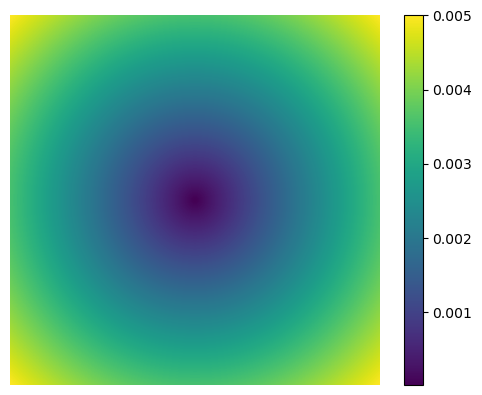

In [4]:
t_r0= 5e-3
t = np.linspace(0, t_r0, 128)
x = np.linspace(-128, 128, 256)
y = np.linspace(-128, 128, 256)
X, Y = np.meshgrid(x, y)
# Compute the radial distance from the centre for each point.
R = np.sqrt(X**2 + Y**2)
R_norm = torch.tensor(R / np.max(R)) # acts as time component
plt.imshow(R_norm*t_r0)
plt.colorbar()
plt.viridis()
plt.axis('off')
plt.savefig(f'pseudo_nufft.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'pseudo_nufft.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)


In [5]:
inv =np.exp(1j * 2 * np.pi * 0*(R_norm*t_r0))

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/1487243208.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  inv =np.exp(1j * 2 * np.pi * 0*(R_norm*t_r0))


In [6]:
inv.shape

torch.Size([256, 256])

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2485439718.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(inv))


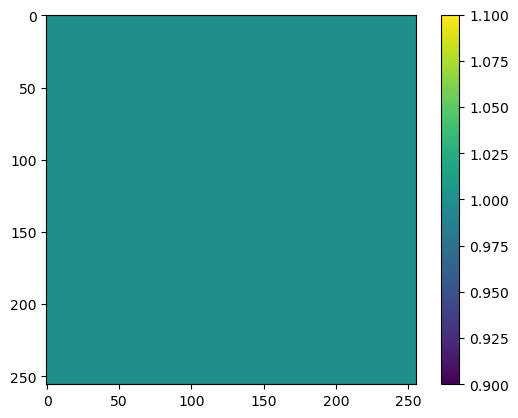

In [7]:
plt.imshow(np.abs(inv))
plt.colorbar()

# MoDL

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        # First 3D convolution to extract features across frequency and spatial dimensions.
        self.conv3d_1 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        # Second 3D convolution to produce a single attention score per frequency bin.
        self.conv3d_2 = nn.Conv3d(in_channels, 1, kernel_size=1)
    
    def forward(self, x):
        # Extract features using a 3D convolution followed by ReLU.
        features = self.conv3d_1(x)
        features = self.relu(features)
        # Compute attention scores.
        scores = self.conv3d_2(features)
        # Apply softmax along the frequency dimension (D, index=2) to get normalised weights.
        weights = F.softmax(scores, dim=2)
        
        # Multiply input with the weights (broadcasting across channels).
        x_conv = self.conv3d_1(x)

        out = x_conv * weights
        return out, weights

class ResidualBlock(nn.Module):
    def __init__(self, channels=128, kernel_size=5):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv3d(channels, channels, kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size, padding=padding)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out
        
class cnn_denoiser(nn.Module):
    def __init__(self, n_layers=3, in_channels=2, out_channels=2, hidden_channels=128):
        super().__init__()
        # 0) Attention module to filter frequency bins.
        self.attention = AttentionModule(hidden_channels)
        
        # 1) Initial convolution to go from in_channels -> hidden_channels.
        self.conv_in = nn.Sequential(
            nn.Conv3d(in_channels, hidden_channels, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, hidden_channels, 5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        # 2) Residual blocks for refinement.
        res_blocks_layers = [ResidualBlock(channels=hidden_channels) for _ in range(n_layers)]
        self.res_blocks = nn.Sequential(*res_blocks_layers)

        # 3) Final convolution to go from hidden_channels -> out_channels.
        self.conv_out = nn.Conv3d(hidden_channels, out_channels, 5, padding=2)

    def forward(self, x):
        # Pass through the initial convolution.
        x_conv = self.conv_in(x)
        
        # Apply the attention module.
        x_attn, weights = self.attention(x_conv)
        
        # Process through the stack of residual blocks.
        in_betw = self.res_blocks(x_attn)
        # Final convolution to restore the number of channels.
        out = self.conv_out(in_betw + x_attn)
        # Global skip connection (using the attention output).
        return out, weights

In [ ]:
def r2c(real_img, axis=0):
    if axis == 0:
        complex_img = real_img[0] + 1j*real_img[1]
    elif axis == 1:
        complex_img = real_img[0][0] + 1j*real_img[0][1]
        complex_img = complex_img.unsqueeze(0)
    else:
        raise NotImplementedError
    return complex_img

def c2r(complex_img, axis=0):

    if isinstance(complex_img, np.ndarray):
        real_img = np.stack((complex_img.real, complex_img.imag), axis=axis)
    elif isinstance(complex_img, torch.Tensor):
        real_img = torch.stack((complex_img.real, complex_img.imag), axis=axis)
        # Maintain device compatibility
        real_img = real_img.to(dtype=torch.float, device=complex_img.device)
    else:
        raise NotImplementedError("Input type not supported for conversion.")
        
    return real_img

#CG algorithm ======================
class myAtA(nn.Module): # LHS of CG
    """
    performs DC step
    """
    def __init__(self, lam, min_freq, max_freq, n_bins, ktraj = None, dcomp = None, csm = None, mask=None):
        super(myAtA, self).__init__()
        self.csm = csm # complex (B x ncoil x nrow x ncol)
        self.mask = mask # complex (B x nrow x ncol)
        self.lam = lam 
        self.freq_bins = np.linspace(min_freq, max_freq, num= n_bins)

    def forward(self, binned_imgs): #step for batch image
        """
        :im: complex image (B x nrow x nrol)
        """
        # print(binned_imgs.shape)
        Ah_y = self.app_traj(binned_imgs.squeeze(0), self.freq_bins)
        # print(Ah_y.shape)
        
        return Ah_y.unsqueeze(0) + self.lam * binned_imgs

    def app_traj(self, binned_imgs,  freq_bins):
        # Prepare freq modulation
        x = np.linspace(-1, 1, binned_imgs[0].shape[1])
        y = np.linspace(-1, 1, binned_imgs[0].shape[0])
        X, Y = np.meshgrid(x, y)
        # Compute the radial distance from the centre for each point.
        R = np.sqrt(X**2 + Y**2)
        R_norm = torch.tensor(R / np.max(R)) # acts as time component
        t_r0= 5e-3
        kdata_sum = torch.zeros((binned_imgs[0].shape[0], binned_imgs[0].shape[1]), dtype= torch.cdouble).to(device)
        # fft
        for i in range(len(freq_bins)):
            I_loop = torch.tensor(binned_imgs[i],dtype=torch.cdouble)
        
            kdata = torch.fft.fft2(I_loop, norm='ortho') # convert into k-space 
            centred_kspace= torch.fft.fftshift(kdata)
            M_delta_fi = torch.exp(1j * 2 * np.pi * freq_bins[i] * (R_norm*t_r0)).to(device)

            kspace_modulated = centred_kspace * M_delta_fi
            kdata_sum += kspace_modulated
    
        #inverse forward model 
        Ah_y = torch.zeros((len(freq_bins),binned_imgs[0].shape[0], binned_imgs[0].shape[1]), dtype= torch.cdouble).to(device)
        for i in range(len(freq_bins)):
            M_delta_fi_conj = torch.exp(-1j * 2 * np.pi * freq_bins[i] * (R_norm*t_r0)).to(device)
            kspace_inv = kdata_sum * M_delta_fi_conj
            distorted_img = torch.fft.ifftshift(kspace_inv)
            distorted_img = torch.fft.ifft2(distorted_img, norm="ortho")
            Ah_y[i] = distorted_img

        
        return Ah_y


def myCG(AtA, rhs):
    """
    Performs Conjugate Gradient (CG) algorithm
    :param AtA: A class object that contains forward and adjoint operations
    :param rhs: Right-hand side vector (complex tensor)
    """
    rhs = r2c(rhs, axis=1)  # Convert to complex form if needed
    # print(rhs.shape)
    x = torch.zeros_like(rhs)  # Initial guess
    r = rhs - AtA(x)  # Initial residual
    
    # # NEW : Remove r from the computational graph to reduce memory overhead
    # r = r.detach()
    p = r.clone()
    rTr = torch.sum(r.conj() * r).real

    for i in range(12):
        if rTr < 1e-12:
            break
        Ap = AtA(p)
        alpha = rTr / torch.sum(p.conj() * Ap).real
        x = x + alpha * p
        r = r - alpha * Ap
        rTrNew = torch.sum(r.conj() * r).real
        beta = rTrNew / rTr
        p = r + beta * p
        rTr = rTrNew
    # print(x.shape)
    # print(c2r(x).shape)
    return c2r(x,1)  # Convert back to real representation


class data_consistency(nn.Module):
    def __init__(self):
        super().__init__()
        self.lam = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    # def forward(self, z_k, x0, csm, mask):
    def forward(self, z_k, x0, min_freq, max_freq, n_bins):
        rhs = x0 + self.lam * z_k # (2, nrow, ncol)
        # print(f'rhs: {rhs.size()}')
        AtA = myAtA(self.lam, min_freq, max_freq, n_bins)
        rec = myCG(AtA, rhs)
        return rec
    

#model =======================    
class MoDL(nn.Module):
    def __init__(self, n_layers, k_iters, min_freq, max_freq, n_bins):
        """
        :n_layers: number of layers
        :k_iters: number of iterations
        """
        super().__init__()
        self.k_iters = k_iters
        self.dw = cnn_denoiser(n_layers) # layers, input bins, output bins
        self.dc = data_consistency()
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_bins = n_bins

    def forward(self, x0, csm=None, mask=None):
        """
        :x0: zero-filled reconstruction (B, 2, nrow, ncol) - float32
        :csm: coil sensitivity map (B, ncoil, nrow, ncol) - complex64
        :mask: sampling mask (B, nrow, ncol) - int8
        """
        
        x_k = x0.clone() #(2, H, W)
        for k in range(self.k_iters):
            # print(x_k.shape)
            z_k, weights = self.dw(x_k) # (2, nrow, ncol); z_k = denoised x_k
            #dc
            x_k = self.dc(z_k, x0, self.min_freq, self.max_freq,self.n_bins) # (2, nrow, ncol)

        x_k=x_k
            
        return x_k,weights

# Trainer

In [10]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/1140411722.py:5: SyntaxWarning: invalid escape sequence '\e'
  """Train simple neural networks


In [ ]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    # y_true_list = []  # to accumulate ground truth for evaluation
    # y_pred_list = []  # to accumulate predictions for evaluation
    start = time.time()
    for (x0, y, x, Ah_y, freq_map) in tqdm(data_loader, desc=desc, leave=False):
        x0, y, x, freq_map= x0.to(device), y.to(device), x.to(device), freq_map.to(device)
        # print(freq_map.size())
#         with torch.set_grad_enabled():
        x_hat, weights = model(x0)
        x_summed = torch.sum(x_hat, 2)
        # print(weights.shape)
        loss_bins = loss_func(x_hat, x)
        # print(loss_bins.shape)
        # loss_per_D = loss_bins.mean(dim=(1, 3, 4))
        loss_freq = loss_func(weights, freq_map.unsqueeze(0).unsqueeze(0))
        
        loss_summed = loss_func(x_summed, y)
        # total_loss = loss_per_D.sum() + loss_summed.mean()
        # total_loss = loss_bins + loss_summed
        # total_loss = loss_per_D.mean()
        total_loss = loss_bins + loss_summed + loss_freq
        
        print(total_loss)
        if model.training:
            # print("training")
            total_loss.backward()
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(total_loss.item())
    # End of epoch: record epoch loss and compute scores
    end = time.time()
    
    results[prefix + " loss"].append(np.mean(running_loss))
    print("Epoch Loss:", np.mean(running_loss))
    
    return end - start  # time spent on epoch

In [12]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

# Checking dataset

In [13]:
path = "synthethic_imgs_5bins_sharp"
dataset = modl_dataset(dataset_path = path,n_bins = 5, min_freq = -220, max_freq =220)

In [14]:
freq_bins = np.linspace(-220, 220,num= 11)
freq_bins

array([-220., -176., -132.,  -88.,  -44.,    0.,   44.,   88.,  132.,
        176.,  220.])

In [15]:
dataset[0][0].shape

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))


torch.Size([2, 5, 256, 256])

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2861398323.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_img))


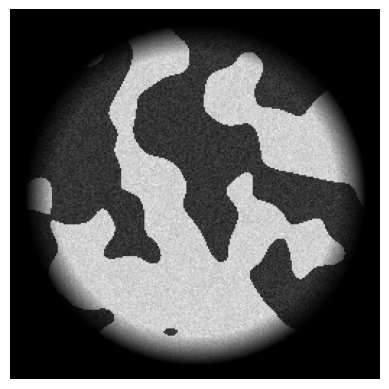

In [21]:
dataset[0][0].shape
gt_img = r2c(dataset[1][1],0)
plt.imshow(np.abs(gt_img))
plt.gray()
plt.axis('off')

plt.savefig('report_data/syn_img_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig('report_data/syn_img_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

In [18]:
binned_imgs = r2c(dataset[1][2])

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))


/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/1331475821.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[i]))


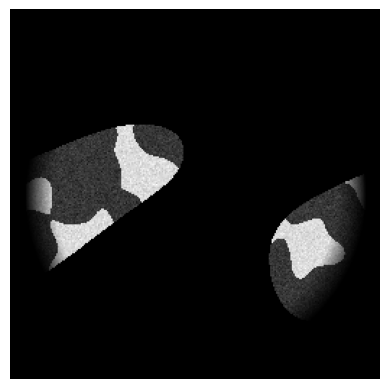

In [19]:
for i in range(6-1):
    # plt.subplot(1,5, i+1)
    plt.imshow(np.abs(binned_imgs[i]))
    # summed_img += soft_binned_imgs[0][...,i]
    plt.axis("off")
    plt.gray()
    plt.savefig(f'report_data/binned_syn_img{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'report_data/binned_syn_img{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.511332.pbs-7/ipykernel_2357411/4039273340.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(Ah_y_img))


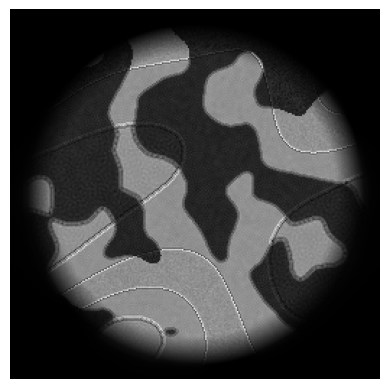

In [20]:

Ah_y_img = dataset[1][3]
plt.imshow(np.abs(Ah_y_img))
plt.gray()
plt.axis('off')

plt.savefig('report_data/syn_img_Ah_y.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig('report_data/syn_img_Ah_y.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

In [20]:
zipped_imgs = np.load(sorted(glob(f"./{path}/imgs*"))[1])
gt = zipped_imgs['composite']
freq_map = zipped_imgs['freq_map']
binned_imgs = zipped_imgs['binned_imgs']

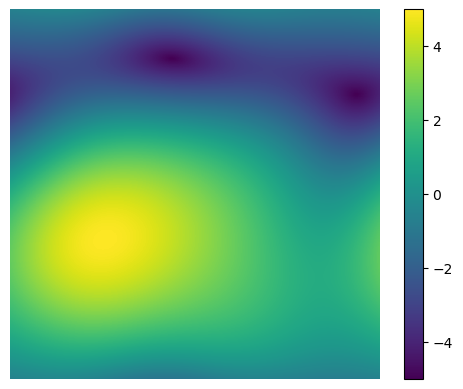

In [21]:
plt.imshow(freq_map)
plt.axis("off")
plt.viridis()
plt.colorbar()
plt.savefig(f'report_data/freq_map.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'report_data/freq_map.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/3920922609.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_bin_img[0]))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/3920922609.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_bin_img[1]

torch.Size([256, 256])

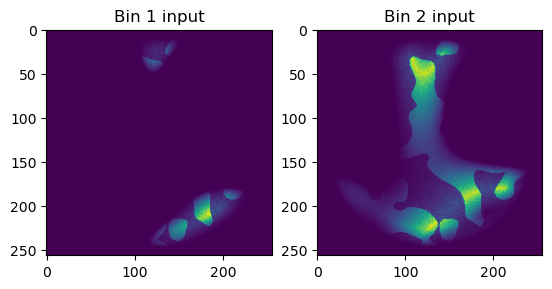

In [22]:
gt_bin_img = r2c(dataset[0][2], 0)
plt.subplot(121)
plt.imshow(np.abs(gt_bin_img[0]))
plt.title("Bin 1 input")
# plt.gray()

plt.subplot(122)
plt.imshow(np.abs(gt_bin_img[1]))
plt.title("Bin 2 input")
# plt.gray()
gt_bin_img[1].shape

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1759906990.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[0].cpu()))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1759906990.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[1]

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

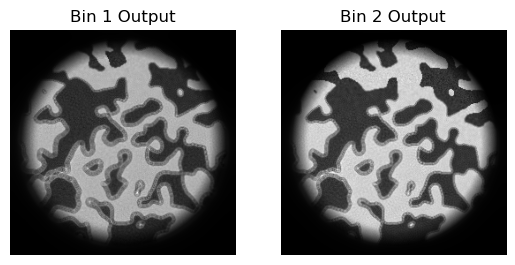

In [23]:
tst_img = r2c(dataset[1][0],0)
plt.subplot(121)
plt.imshow(np.abs(tst_img[0].cpu()))
plt.title("Bin 1 Output")
plt.gray()
plt.axis('off')

plt.subplot(122)
plt.imshow(np.abs(tst_img[1].cpu()))
plt.title("Bin 2 Output")
plt.gray()
plt.axis('off')

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/932500738.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[i]).cpu())


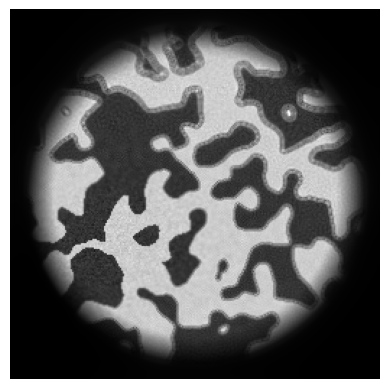

In [24]:
for i in range(6-1):
    # plt.subplot(1,5, i+1)
    plt.imshow(np.abs(tst_img[i]).cpu())
    # summed_img += soft_binned_imgs[0][...,i]
    plt.axis("off")
    plt.gray()
    plt.savefig(f'report_data/binned_syn_img{i}_fm.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'report_data/binned_syn_img{i}_fm.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/3070117427.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[0]-gt_img))


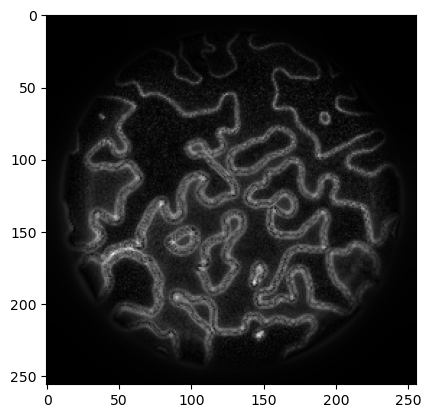

In [25]:
plt.imshow(np.abs(tst_img[0]-gt_img))

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2384214249.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[1].cpu()))


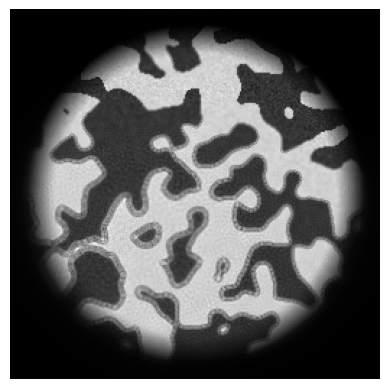

In [26]:
plt.imshow(np.abs(tst_img[1].cpu()))
plt.axis('off')

plt.savefig('report_data/syn_img_bin.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig('report_data/syn_img_bin.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1435225039.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_bin_img[1]))


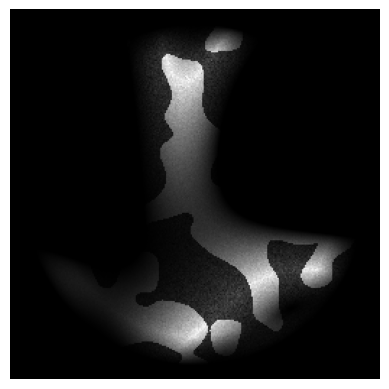

In [27]:
plt.imshow(np.abs(gt_bin_img[1]))
plt.axis('off')

plt.savefig('report_data/syn_img_bin_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig('report_data/syn_img_bin_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

# Train

In [42]:
n_bins = 5
train_path = f"synthethic_imgs_{n_bins}bins_sharp_softbins"
# train_path = f"synthethic_imgs_{n_bins}bins_sharp_softbins"
train_dataset = modl_dataset(dataset_path = train_path,n_bins = n_bins, min_freq = -220, max_freq =220)

eval_path = f"synthethic_imgs_{n_bins}bins_sharp_softbins_eval"
# eval_path = f"synthethic_imgs_{n_bins}bins_sharp_softbins_eval"
eval_dataset = modl_dataset(dataset_path = eval_path,n_bins = n_bins, min_freq = -220, max_freq =220)

In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle = True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle = True)

In [44]:
loss_func = nn.L1Loss(reduction='mean')
n_layer = 3
k_iter= 4
n_bins = n_bins
min_freq = -220
max_freq = 220
model = MoDL(n_layer, k_iter, min_freq, max_freq, n_bins)
model = model.to(device)
optimizer =torch.optim.AdamW(model.parameters(), lr=1e-5) 

In [24]:
modl_results = train_network(model, loss_func, train_dataloader, val_loader= eval_dataloader, epochs=30, device=device, optimizer=optimizer, checkpoint_file="modl_020625_test.pth")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]
/var/tmp/pbs.487998.pbs-7/ipykernel_1848484/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.487998.pbs-7/ipykernel_1848484/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.487998.pbs-7/ipykernel_1848484/672513438.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(binned_imgs[i],dtype=torch.cdouble)
/rds/general/user/abs121/home/miniforge3/envs/fyp_2/lib/python3.12/site-packages/torch/nn/modules/lo

tensor(2.4200, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   1%|          | 1/100 [00:16<26:50, 16.27s/it]

tensor(1.9989, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   2%|▏         | 2/100 [00:28<22:56, 14.04s/it]

tensor(2.1977, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   3%|▎         | 3/100 [00:41<21:39, 13.40s/it]

tensor(1.9194, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   4%|▍         | 4/100 [00:54<21:01, 13.14s/it]

tensor(2.1154, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   5%|▌         | 5/100 [01:06<20:37, 13.03s/it]

tensor(2.4826, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   6%|▌         | 6/100 [01:19<20:17, 12.96s/it]

tensor(2.0248, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   7%|▋         | 7/100 [01:32<20:02, 12.93s/it]

tensor(1.9715, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   8%|▊         | 8/100 [01:45<19:50, 12.94s/it]

tensor(2.1136, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:   9%|▉         | 9/100 [01:58<19:36, 12.93s/it]

tensor(2.1132, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  10%|█         | 10/100 [02:11<19:21, 12.91s/it]

tensor(2.0016, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  11%|█         | 11/100 [02:24<19:07, 12.89s/it]

tensor(2.1459, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  12%|█▏        | 12/100 [02:37<18:54, 12.89s/it]

tensor(2.0552, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  13%|█▎        | 13/100 [02:49<18:40, 12.88s/it]

tensor(2.1047, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  14%|█▍        | 14/100 [03:02<18:27, 12.88s/it]

tensor(2.0382, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



ining:  15%|█▌        | 15/100 [03:15<18:14, 12.88s/it]

tensor(2.2417, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)



Epoch:   0%|          | 0/30 [03:28<?, ?it/s]             
/var/tmp/pbs.487998.pbs-7/ipykernel_1848484/1140411722.py:5: SyntaxWarning: invalid escape sequence '\e'
  """Train simple neural networks


KeyboardInterrupt: 

In [ ]:
df.to_csv("my_data.csv", index=False)

In [ ]:
modl_results.plot(x='epoch', y='train loss')

In [ ]:
modl_results.plot(x='epoch', y='val loss')

# Eval

In [50]:
n_bins = 5
checkpoint = torch.load('modl_020625_attn_sharp_fw_fmap_5bin_softbins_5e-3_spv_attn.pth')
# checkpoint = torch.load(f'modl_26030225_attn_sharp_fw_fmap_11bin_5e-4.pth')
loss_func = nn.L1Loss(reduction='mean')
n_layer = 3
k_iter= 4

min_freq = -220
max_freq = 220
model = MoDL(n_layer, k_iter, min_freq, max_freq, n_bins)
model = model.to(device)
optimizer =torch.optim.AdamW(model.parameters(), lr=1e-5) 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/3883499722.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('modl_020625_attn_sharp_fw_fmap_5bin_softb

MoDL(
  (dw): cnn_denoiser(
    (attention): AttentionModule(
      (conv3d_1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU(inplace=True)
      (conv3d_2): Conv3d(128, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (conv_in): Sequential(
      (0): Conv3d(2, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (1): ReLU(inplace=True)
      (2): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (3): ReLU(inplace=True)
    )
    (res_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      )
      (1): ResidualBlock(
        (conv1): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
        (relu): ReLU(inplace=True)
        (conv2): Conv

# Brain MRI

In [28]:
from SyntheticDataGenerator_sharp import SyntheticDataGenerator_sharp
class brain_dataset(Dataset):
    def __init__(self, mode, dataset_path, gt_shape=(256,256)):
        """
        :sigma: std of Gaussian noise to be added in the k-space
        """
        self.prefix = 'trn' if mode == 'train' else 'tst'
        self.dataset_path = dataset_path
#         self.sigma = sigma
    

    def __getitem__(self, index):
        """
        :x0: zero-filled reconstruction (2 x nrow x ncol) - float32
        :gt: fully-sampled image (2 x nrow x ncol) - float32
        :csm: coil sensitivity map (ncoil x nrow x ncol) - complex64
        :mask: undersample mask (nrow x ncol) - int8
        """
        with h5.File(self.dataset_path, 'r') as f:
            gt = f[self.prefix+'Org'][index]
            gt = np.abs(gt)
            gt_torch = F.interpolate(torch.from_numpy(gt).unsqueeze(0).unsqueeze(0), (256, 256))
            gt_torch = gt_torch.squeeze(0).squeeze(0).to(dtype=complex)
        return gt_torch

    def __len__(self):
        with h5.File(self.dataset_path, 'r') as f:
            num_data = len(f[self.prefix+'Mask'])
        return num_data

    

In [30]:
mode = "test"
path = "dataset.hdf5"
dataset_test = brain_dataset(mode = mode, dataset_path = path)

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/3967392166.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_brain_img))


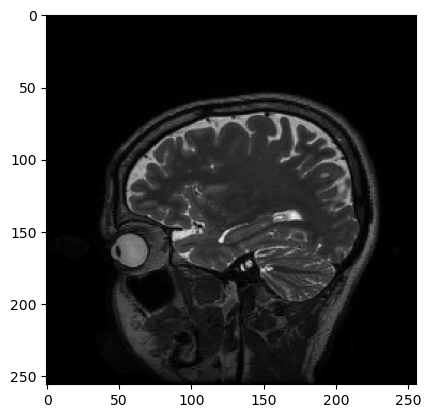

In [31]:
tst_brain_img = dataset_test[50]
plt.imshow(np.abs(tst_brain_img))

In [33]:
nx, ny = 256, 256
min_freq = -220
max_freq = 220
n_images = 1
num_bins = 6
data_gen = SyntheticDataGenerator_sharp(nx, ny, n_images, min_freq, max_freq)
freq_map = data_gen.generate_field_map()
# binned_imgs = np.expand_dims(data_gen.create_freq_bin_image(tst_brain_img, freq_map, num_bins), axis=0)
binned_imgs= data_gen.create_soft_freq_bin_image(tst_brain_img,freq_map, min_freq, max_freq, num_bins-1)


/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/2692741385.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,i]))


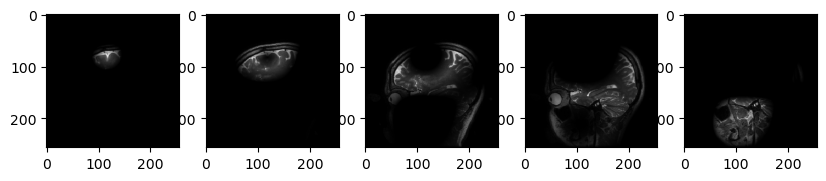

In [34]:
# binned_imgs = binned_imgs[..]
plt.figure(figsize=(12,4))
for i in range(num_bins-1):
    plt.subplot(1, num_bins, i+1)
    # plt.imshow(np.abs(fat_map), cmap ='gray')
    plt.imshow(np.abs(binned_imgs[0][...,i]))

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1193320978.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_brain_img))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1193320978.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,0]))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1193320978.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,1]))


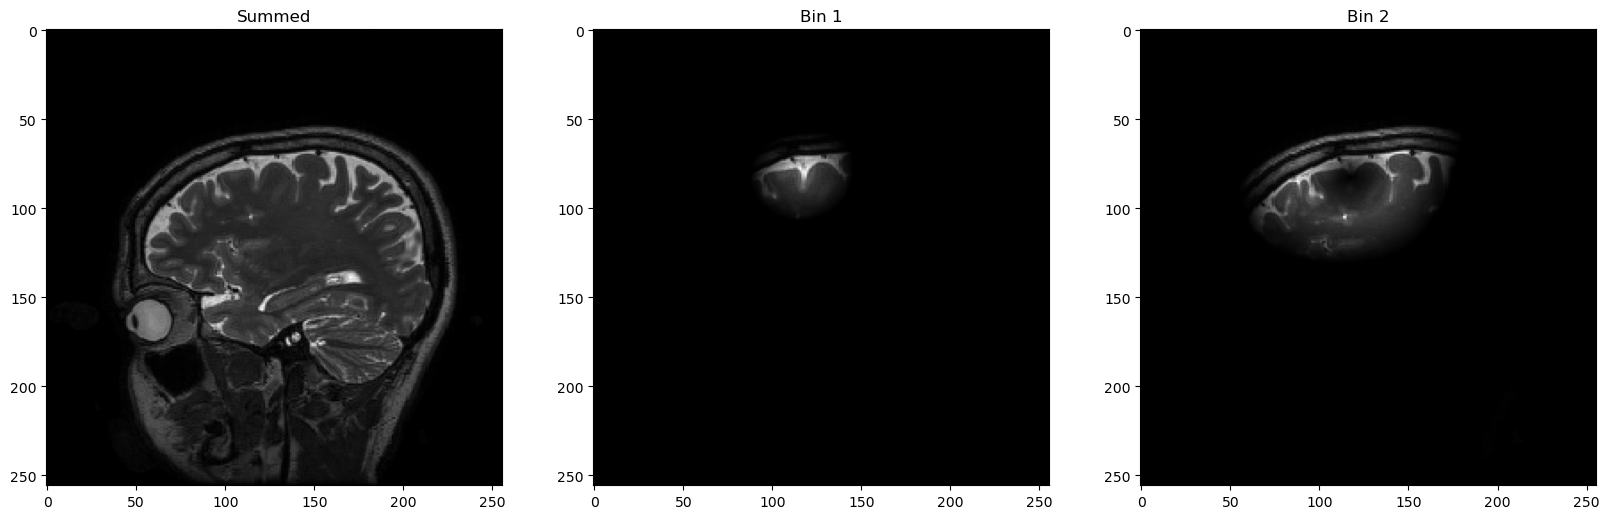

In [35]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(np.abs(tst_brain_img))
plt.title("Summed")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(binned_imgs[0][...,0]))
plt.title("Bin 1")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(binned_imgs[0][...,1]))
plt.title("Bin 2")
plt.gray()

# plt.savefig('modl_recon_c_50')

In [37]:
n_bins = 5
min_freq = -220
max_freq = 220
freq_bins = np.linspace(min_freq, max_freq, num= n_bins)
x0 = app_traj(binned_imgs[0],  freq_bins)

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/2866942999.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(binned_imgs[...,i],dtype=torch.cdouble)
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))


In [65]:
binned_imgs[0].shape

torch.Size([256, 256, 11])

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/3574758354.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(x0[0][0]))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/3574758354.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(x0[0][1]))


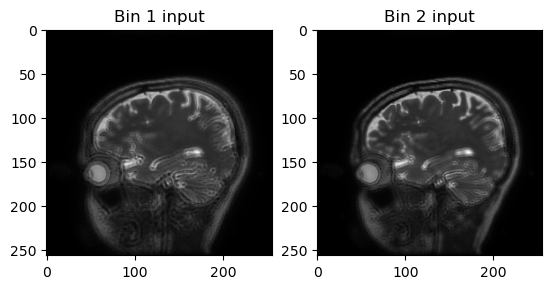

In [38]:
plt.subplot(121)
plt.imshow(np.abs(x0[0][0]))
plt.title("Bin 1 input")
plt.gray()

plt.subplot(122)
plt.imshow(np.abs(x0[0][1]))
plt.title("Bin 2 input")
plt.gray()

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/4026538922.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(A_img))


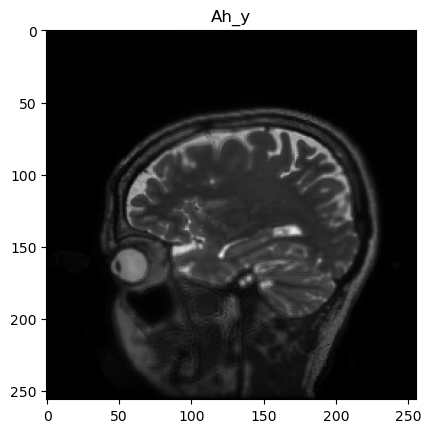

In [39]:
A_img = torch.fft.ifftshift(x0[1])
A_img = torch.fft.ifft2(A_img)
plt.imshow(np.abs(A_img))
plt.title("Ah_y")
plt.gray()

In [40]:
with torch.no_grad():
    tst_data, weights = model(c2r(torch.tensor(x0[0], dtype=torch.cdouble)).to(device).unsqueeze(0))
tst_data.shape
# summed_img = r2c(tst_data[1].squeeze(0).detach().cpu())
# binned_img = r2c(tst_data[0].squeeze(0).detach().cpu()) 

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/745782697.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tst_data, weights = model(c2r(torch.tensor(x0[0], dtype=torch.cdouble)).to(device).unsqueeze(0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/672513438.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(binned_imgs[i],dtype=torch.cdouble)


torch.Size([1, 2, 5, 256, 256])

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1217864610.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[i]))


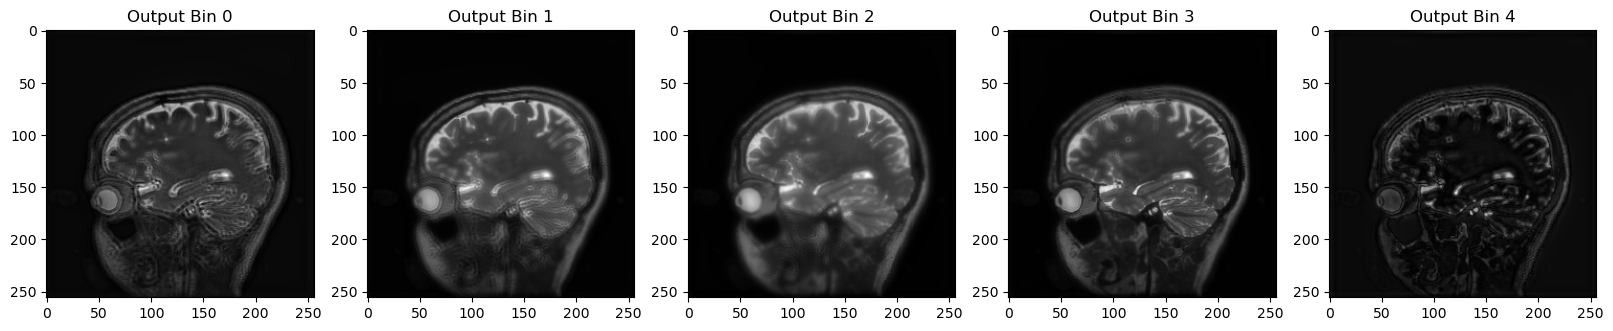

In [41]:
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu(),0)
 
summed_img = np.zeros_like(binned_img[0])
plt.figure(figsize=(20,40))
for i in range(n_bins):
    plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.title(f"Output Bin {i}")
    plt.gray()
    summed_img += binned_img[i].numpy()

/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1132707164.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[0]))
/var/tmp/pbs.497715.pbs-7/ipykernel_1918166/1132707164.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[1]))


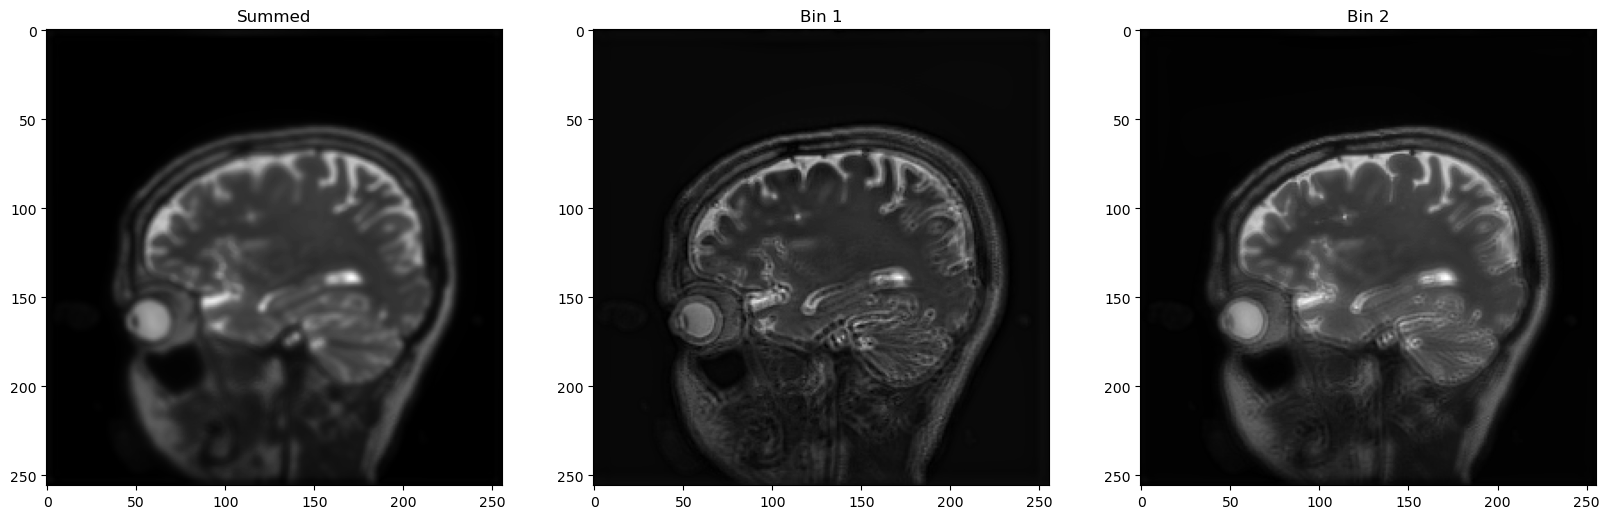

In [42]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(np.abs(summed_img))
plt.title("Summed")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(binned_img[0]))
plt.title("Bin 1")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(binned_img[1]))
plt.title("Bin 2")
plt.gray()

# plt.savefig('modl_recon_c_50')

# Synthetic Data

In [51]:
idx = 40
n_bins = 5
with torch.no_grad():
    tst_data, weights = model(eval_dataset[idx][0].to(device).unsqueeze(0))
tst_data[0].type()

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/672513438.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(binned_imgs[i],dtype=torch.cdouble)


'torch.cuda.FloatTensor'

In [37]:
weights.shape

torch.Size([1, 1, 11, 256, 256])

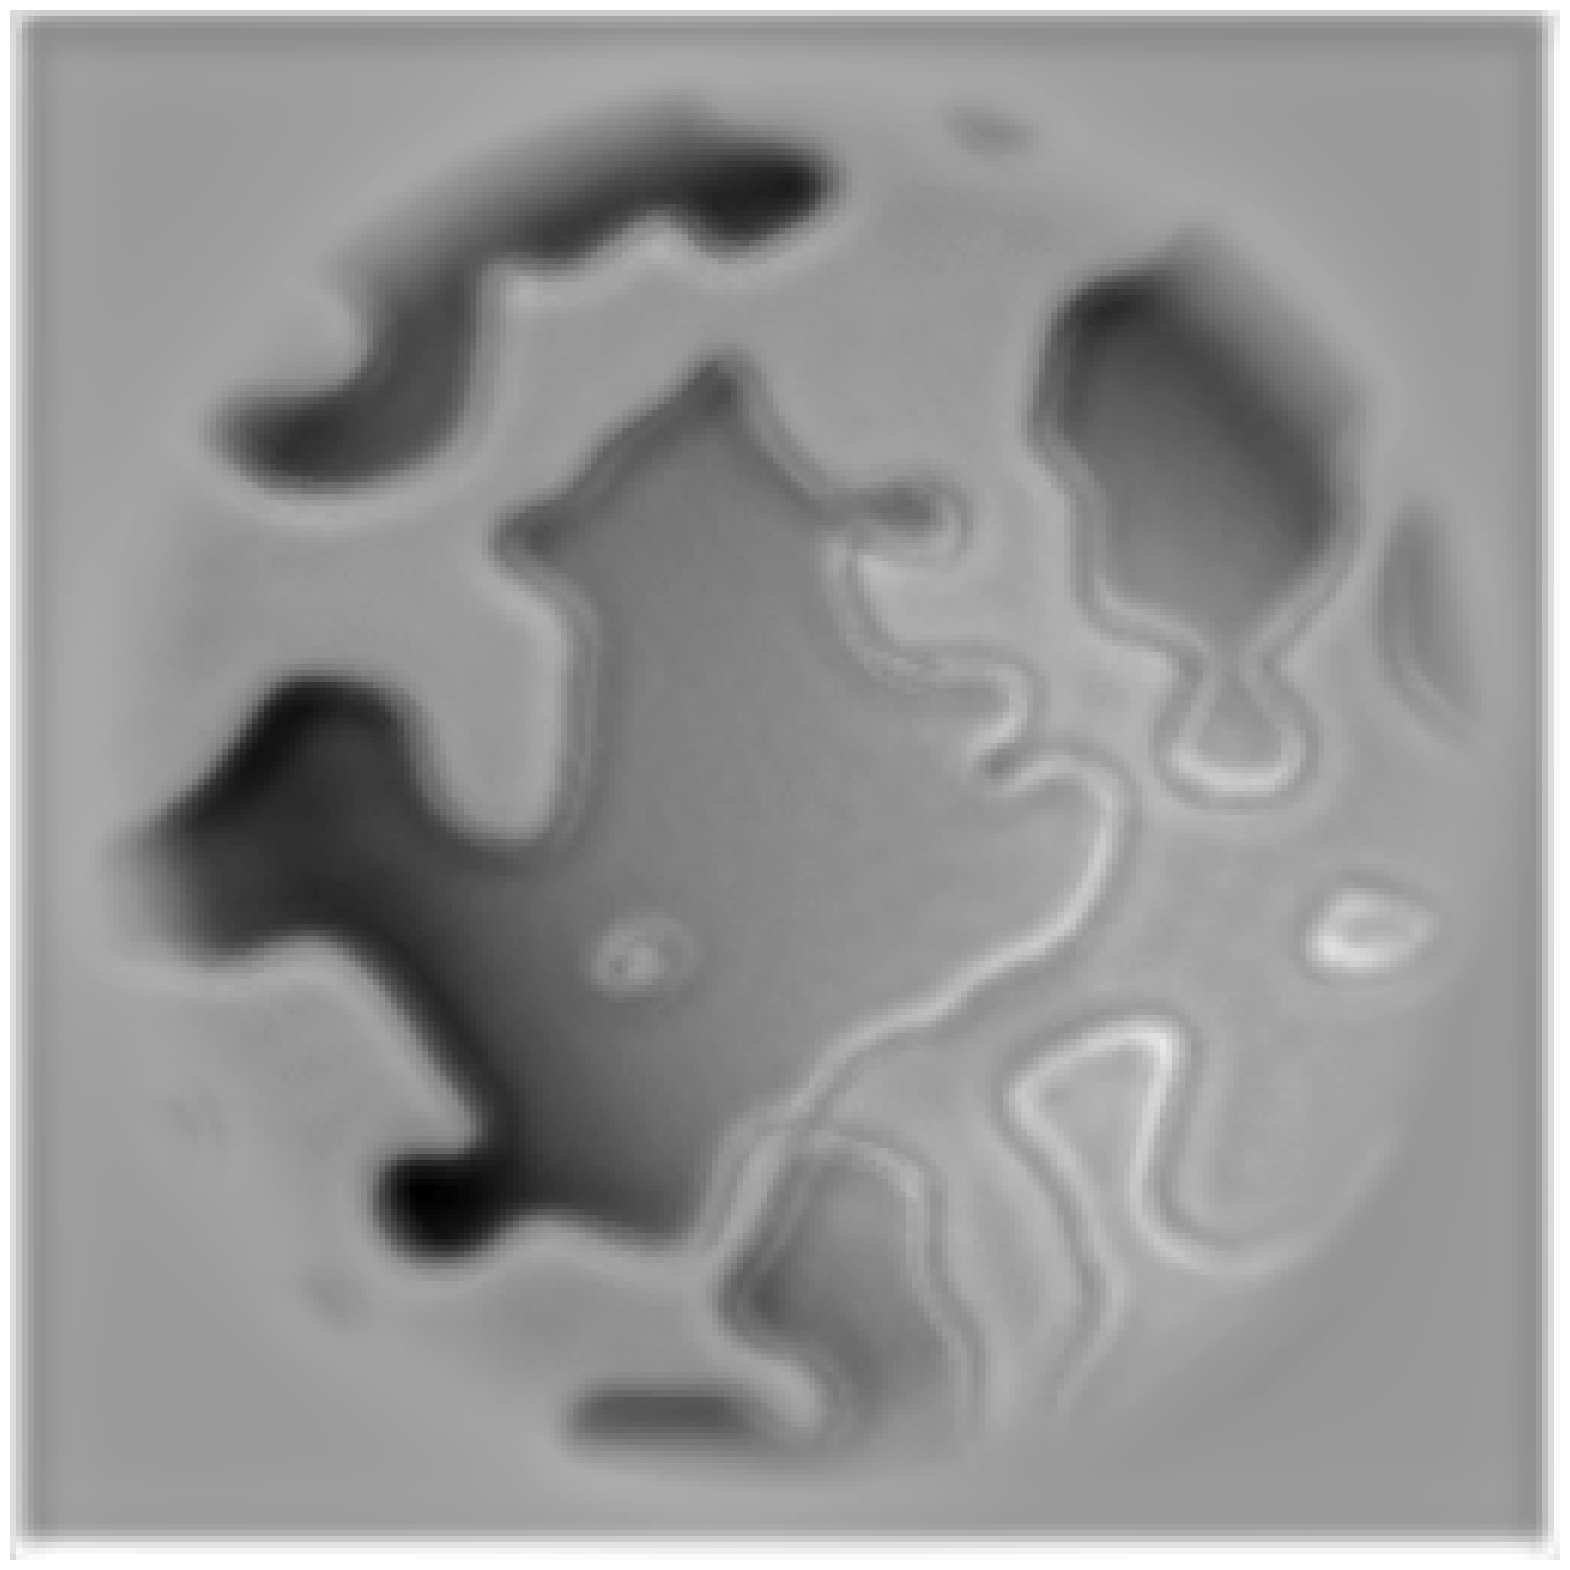

In [52]:
path = f"synthethic_imgs_5bins_sharp_softbins"
save_path = f'report_data/{path}'
plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    plt.imshow(weights[0][0][i].detach().cpu())
    # plt.title(f"Output Bin {i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/syn_img_weights{i}_spv.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_weights{i}_spv.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    # summed_img += binned_img[i].numpy()

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1404523550.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(Ah_y))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1404523550.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[0]))
/var/

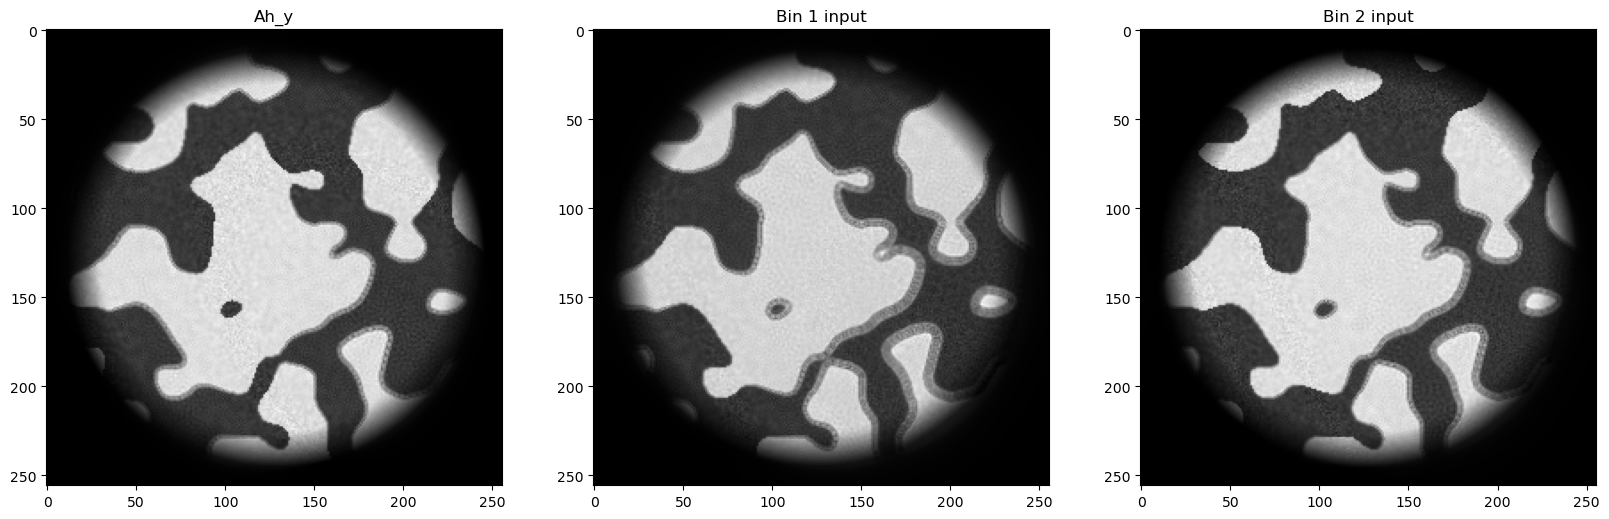

In [54]:
path = "synthethic_imgs_5bins_sharp_softbins_eval"
dataset = modl_dataset(dataset_path = path,n_bins = n_bins, min_freq = -220, max_freq =220)
tst_binned = r2c(dataset[idx][0],0)
tst_binned.shape

plt.figure(figsize=(20,10))
Ah_y = dataset[idx][3]
plt.subplot(131)
plt.imshow(np.abs(Ah_y))
plt.title("Ah_y")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(tst_binned[0]))
plt.title("Bin 1 input")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(tst_binned[1]))
plt.title("Bin 2 input")
plt.gray()

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/1217864610.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[i]))


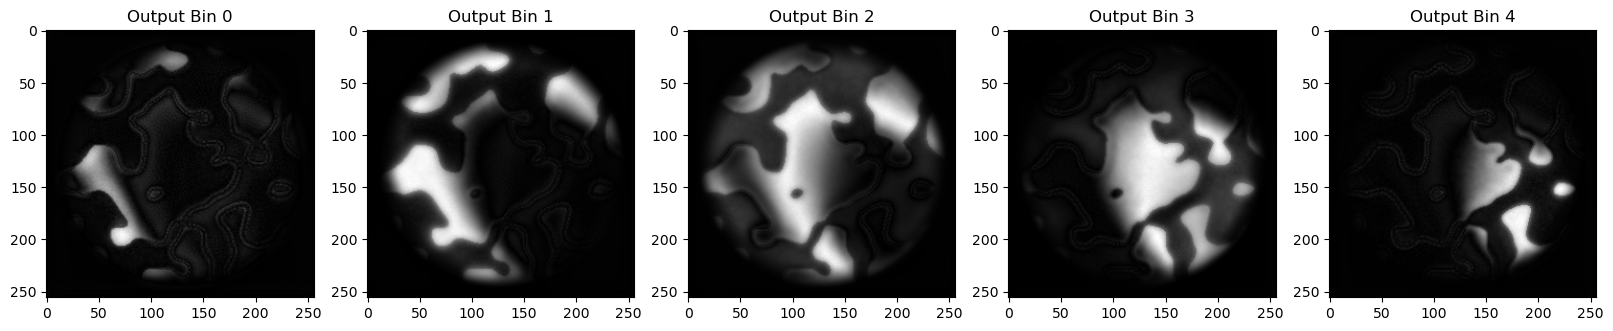

In [56]:
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu(),0)
 
summed_img = np.zeros_like(binned_img[0])
plt.figure(figsize=(20,40))
for i in range(n_bins):
    plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.title(f"Output Bin {i}")
    plt.gray()
    plt.savefig(f'{save_path}/syn_img_bin{i}_spv.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_weights{i}_spv.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.510582.pbs-7/ipykernel_2347333/573344701.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[i]))


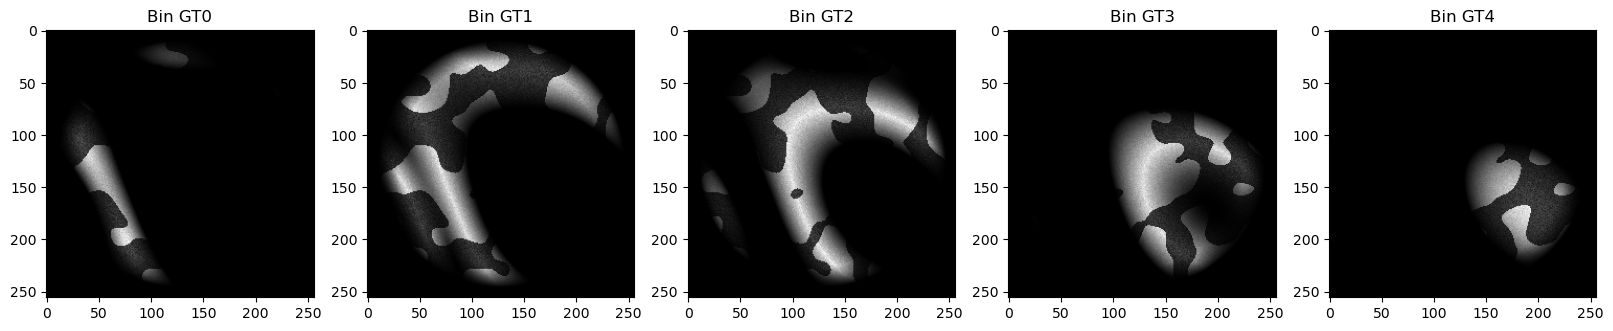

In [57]:
tst_binned = r2c(dataset[idx][2],0)
tst_binned.shape



plt.figure(figsize=(20,10))
summed_gt_img = np.zeros_like(binned_img[0])
for i in range(n_bins):
    plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(tst_binned[i]))
    plt.title(f"Bin GT{i}")
    plt.gray()
    summed_gt_img += binned_img[i].numpy()

/var/tmp/pbs.497715.pbs-7/ipykernel_1916476/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1916476/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1916476/3689411650.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_gt))


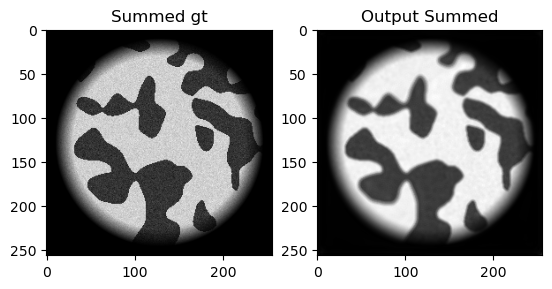

In [86]:
tst_gt = r2c(dataset[idx][1],0)

plt.subplot(121)
plt.imshow(np.abs(tst_gt))
plt.title("Summed gt")
plt.gray()


plt.subplot(122)
plt.imshow(np.abs(summed_img))
plt.title("Output Summed")
plt.gray()

Text(0.5, 1.0, 'Absolute Difference')

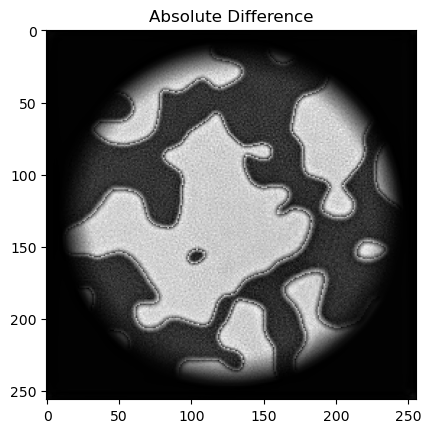

In [38]:
plt.imshow(np.abs(summed_img-tst_gt.numpy()))
plt.title("Absolute Difference")

# Evaluation

In [29]:
from SyntheticDataGenerator_sharp import SyntheticDataGenerator_sharp
class brain_dataset(Dataset):
    def __init__(self, mode, dataset_path, gt_shape=(256,256)):
        """
        :sigma: std of Gaussian noise to be added in the k-space
        """
        self.prefix = 'trn' if mode == 'train' else 'tst'
        self.dataset_path = dataset_path
#         self.sigma = sigma
    
    def __getitem__(self, index):
        """
        :x0: zero-filled reconstruction (2 x nrow x ncol) - float32
        :gt: fully-sampled image (2 x nrow x ncol) - float32
        :csm: coil sensitivity map (ncoil x nrow x ncol) - complex64
        :mask: undersample mask (nrow x ncol) - int8
        """
        with h5.File(self.dataset_path, 'r') as f:
            gt = f[self.prefix+'Org'][index]
            gt = np.abs(gt)
            gt_torch = F.interpolate(torch.from_numpy(gt).unsqueeze(0).unsqueeze(0), (256, 256))
            gt_torch = gt_torch.squeeze(0).squeeze(0).to(dtype=complex)
        return gt_torch

    def __len__(self):
        with h5.File(self.dataset_path, 'r') as f:
            num_data = len(f[self.prefix+'Mask'])
        return num_data

In [ ]:
import os
import pandas as pd

# path = f"synthethic_imgs_{n_bins}bins_sharp_eval"
path = f"synthethic_imgs_{n_bins}bins_sharp_softbins"
save_path = f'report_data/{path}'

if not os.path.exists(save_path):
    # At this point, we know the directory is absent.
    os.makedirs(save_path)
    # Now the directory (and any necessary parent directories) has been created.
else:
    # If it already exists, we do nothing.
    pass



dataset = modl_dataset(dataset_path = path,n_bins = n_bins, min_freq = -220, max_freq =220)

result = {}
result['idx'] =[]
result['nrmse'] =[]
for i in range(len(dataset)):
    with torch.no_grad():
        out_data, weights = model(eval_dataset[i][0].to(device).unsqueeze(0))
    binned_img = r2c(out_data[0].squeeze(0).detach().cpu(),0)
    summed_img = np.zeros_like(binned_img[0])
    for n in range(n_bins):
        summed_img += binned_img[n].numpy()
    tst_gt = r2c(dataset[i][1],0)
    nrmse_result = compute_image_nrmse(np.abs(tst_gt), np.abs(summed_img), normalisation='range')

    result['idx'].append(i)
    result['nrmse'].append(nrmse_result)
    print(f"idx : {i}, NRMSE (range-based) : {nrmse_result:.4f}")
result_pd=pd.DataFrame.from_dict(result)
result_pd.to_csv(f'{save_path}/{path}_spv_attn.csv', index=False)

mode = "test"
brain_path = "dataset.hdf5"
brain_dataset_eval = brain_dataset(mode = mode, dataset_path = brain_path)

nx, ny = 256, 256
min_freq = -220
max_freq = 220
n_images = 1
num_bins = n_bins +1 
freq_bins = np.linspace(min_freq, max_freq, num= n_bins)
brain_data_gen = SyntheticDataGenerator_sharp(nx, ny, n_images, min_freq, max_freq)


result = {}
result['idx'] =[]
result['nrmse'] =[]
for i in range(len(brain_dataset_eval)):
    freq_map = brain_data_gen.generate_field_map()
    
    brain_binned_imgs= brain_data_gen.create_soft_freq_bin_image(brain_dataset_eval[i],freq_map, min_freq, max_freq, num_bins-1)
    # brain_binned_imgs= np.expand_dims(data_gen.create_freq_bin_image(brain_dataset_eval[i], freq_map, num_bins), axis=0)
    # print(brain_dataset_eval[0].shape)
    x0 = app_traj(brain_binned_imgs[0],  freq_bins)
    with torch.no_grad():
        out_data, weights =  model(c2r(torch.tensor(x0[0], dtype=torch.cdouble)).to(device).unsqueeze(0))
    binned_img = r2c(out_data[0].squeeze(0).detach().cpu(),0)
    summed_img = np.zeros_like(binned_img[0])
    for n in range(n_bins):
        summed_img += binned_img[n].numpy()
    # tst_gt = r2c(brain_dataset_eval[i],0)
    nrmse_result = compute_image_nrmse(np.abs(brain_dataset_eval[i]), np.abs(summed_img), normalisation='range')

    result['idx'].append(i)
    result['nrmse'].append(nrmse_result)
    print(f"brain idx : {i}, NRMSE (range-based) : {nrmse_result:.4f}")
result_pd=pd.DataFrame.from_dict(result)
result_pd.to_csv(f'{save_path}/brain_spv_attn.csv', index=False)


/var/tmp/pbs.508004.pbs-7/ipykernel_1951852/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.508004.pbs-7/ipykernel_1951852/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.508004.pbs-7/ipykernel_1951852/823056732.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(Ah_y_binned[i]))
/var/tmp/pbs.508004.pbs-7/ipykernel_1951852/823056732.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(Ah_y))
/var/

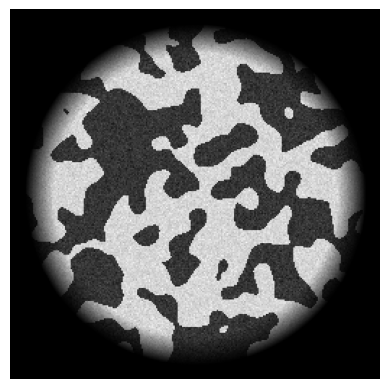

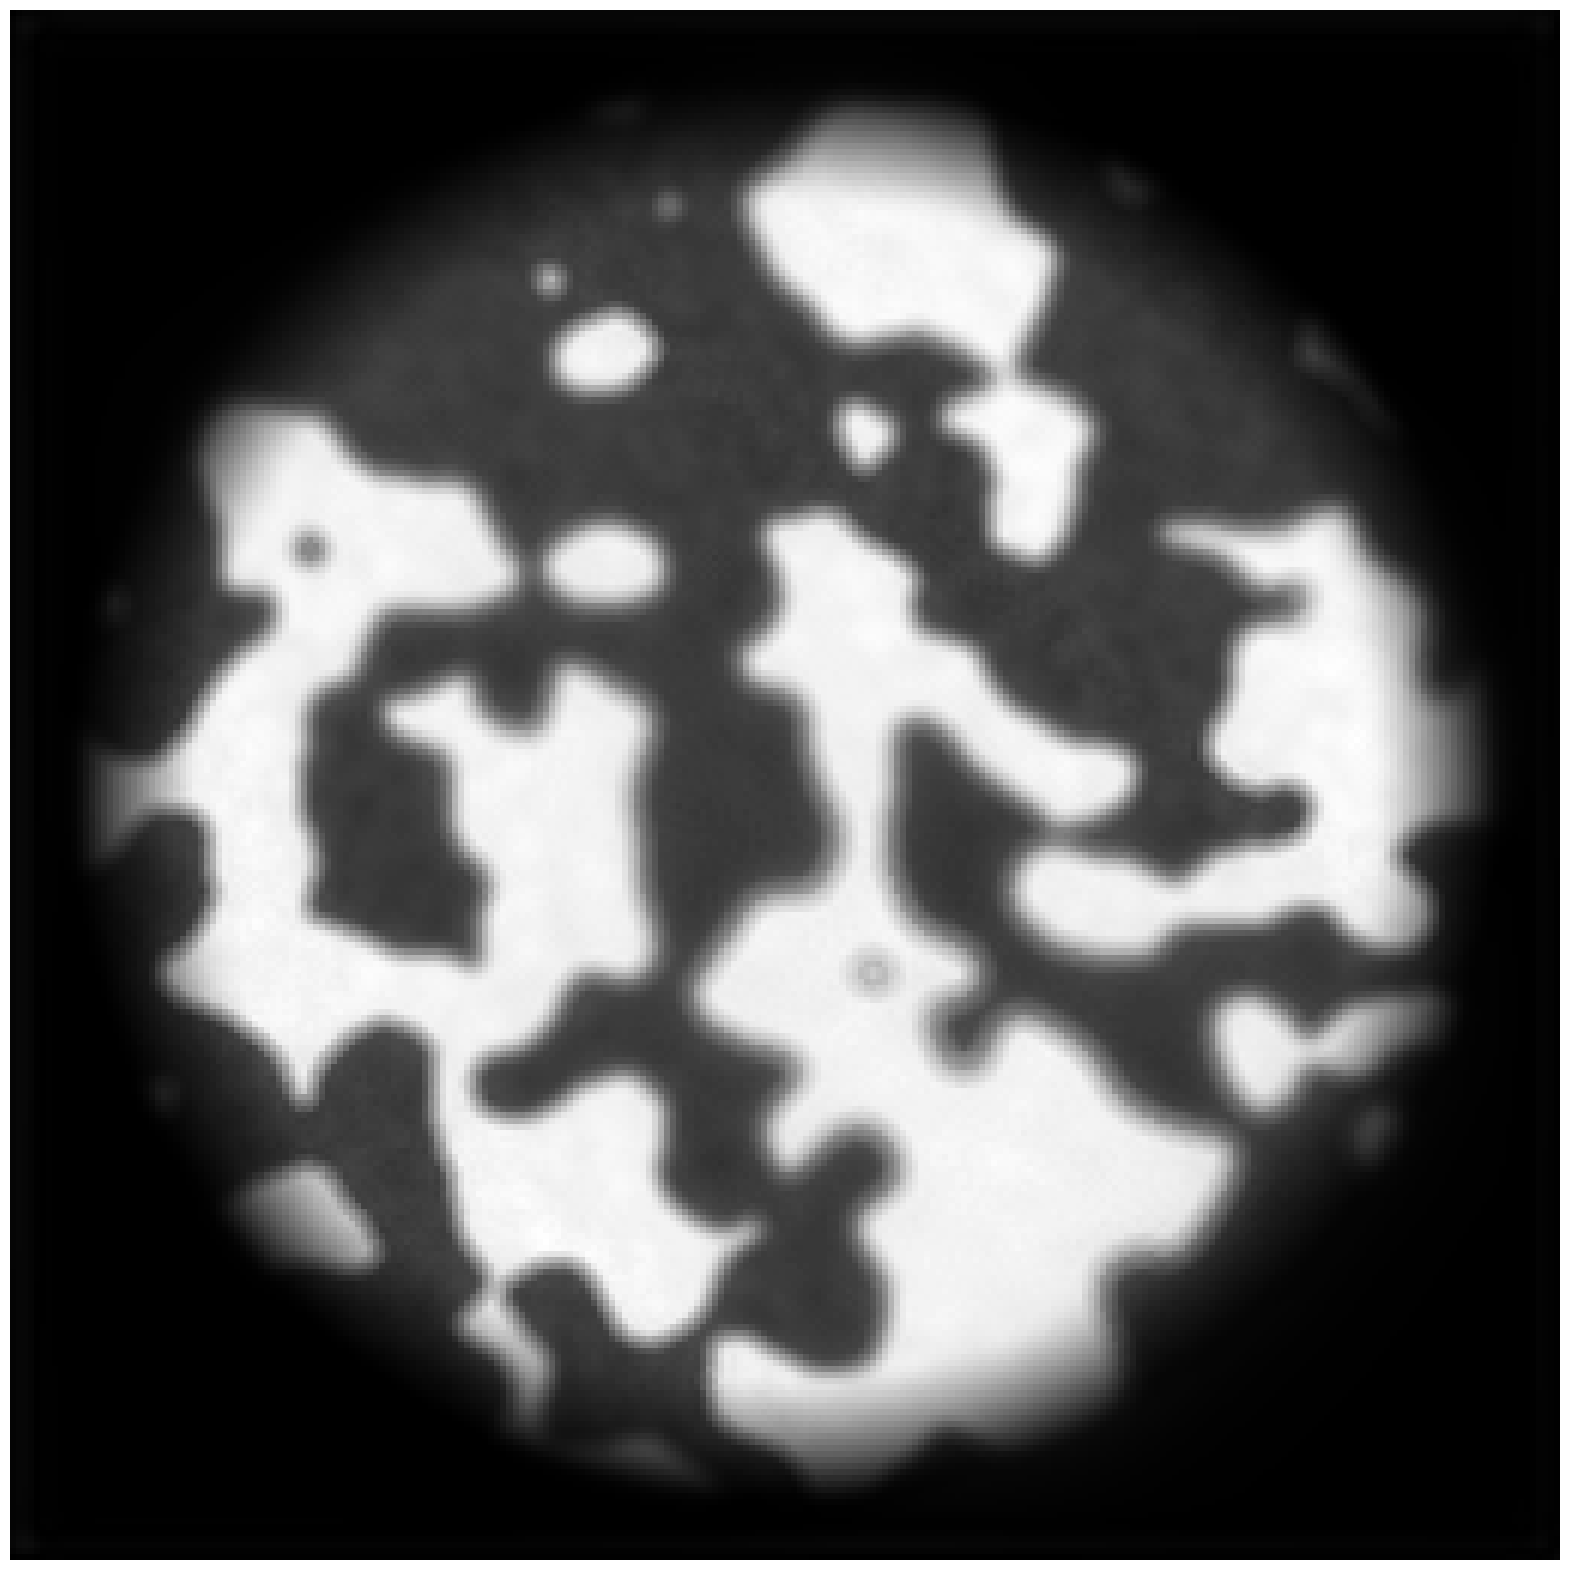

In [37]:
idx = 1
#Ah_y
# path = f"synthethic_imgs_{n_bins}bins_sharp_softbins_eval"
# path = f"synthethic_imgs_{n_bins}bins_sharp_eval"

path = f"synthethic_imgs_{n_bins}bins_sharp_softbins"
save_path = f'report_data/{path}'
dataset = modl_dataset(dataset_path = path,n_bins = n_bins, min_freq = -220, max_freq =220)
Ah_y_binned = r2c(dataset[idx][0],0)

for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    plt.imshow(np.abs(Ah_y_binned[i]))
    # plt.title(f"Bin GT{i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/syn_img_Ah_y_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_Ah_y_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    
Ah_y = dataset[idx][3]
plt.imshow(np.abs(Ah_y))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/syn_img_A_img.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_A_img.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

# GT
gt_binned = r2c(dataset[idx][2],0)
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    plt.imshow(np.abs(gt_binned[i]))
    # plt.title(f"Bin GT{i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/syn_img_gt_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_gt_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

gt_img = r2c(dataset[idx][1],0)

plt.imshow(np.abs(gt_img))

plt.savefig(f'{save_path}/syn_img_summed_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_summed_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

#output
with torch.no_grad():
        out_data, weights = model(eval_dataset[idx][0].to(device).unsqueeze(0))
binned_img = r2c(out_data[0].squeeze(0).detach().cpu(),0)
summed_img = np.zeros_like(binned_img[0])
# plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.axis('off')
    # plt.title(f"Output Bin {i}")
    plt.gray()
    plt.savefig(f'{save_path}/syn_img_out_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_out_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    summed_img += binned_img[i].numpy()

plt.imshow(np.abs(summed_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/syn_img_summed_out.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_summed_out.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)


/var/tmp/pbs.497715.pbs-7/ipykernel_1920053/2866942999.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(binned_imgs[...,i],dtype=torch.cdouble)
/var/tmp/pbs.497715.pbs-7/ipykernel_1920053/2866942999.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi =  np.exp(1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1920053/2866942999.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi_conj = np.exp(-1j * 2 * np.pi * freq_bins[i]*(R_norm*t_r0))
/var/tmp/pbs.497715.pbs-7/ipykernel_1920053/2267752922.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar argume

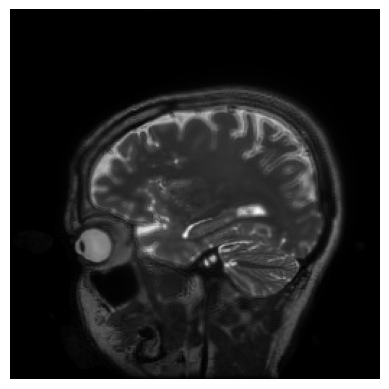

In [55]:
idx = 50
#Ah_y
# path = f"synthethic_imgs_{n_bins}bins_sharp_softbins_eval"
brain_data_gen = SyntheticDataGenerator_sharp(nx, ny, n_images, min_freq, max_freq)
brain_dataset_eval = brain_dataset(mode = mode, dataset_path = brain_path)
freq_map = brain_data_gen.generate_field_map()

brain_binned_imgs= brain_data_gen.create_soft_freq_bin_image(brain_dataset_eval[idx],freq_map, min_freq, max_freq, num_bins-1)
# brain_binned_imgs= np.expand_dims(data_gen.create_freq_bin_image(brain_dataset_eval[idx], freq_map, num_bins), axis=0)
Ah_y_binned = app_traj(brain_binned_imgs[0],  freq_bins)

for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    plt.imshow(np.abs(Ah_y_binned[0][i]))
    # plt.title(f"Bin GT{i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/brain_img_Ah_y_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/brain_img_Ah_y_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

A_img = torch.fft.ifftshift(Ah_y_binned[1])
A_img = torch.fft.ifft2(A_img)
plt.imshow(np.abs(A_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/brain_img_A_img.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/brain_img_A_img.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

# GT
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    plt.imshow(np.abs(brain_binned_imgs[0][...,i]))
    # plt.title(f"Bin GT{i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/brain_img_gt_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/brain_img_gt_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

gt_img = brain_dataset_eval[idx]

plt.imshow(np.abs(gt_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/brain_img_summed_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/brain_img_summed_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

#output
with torch.no_grad():
        out_data, weights = model(c2r(torch.tensor(Ah_y_binned[0], dtype=torch.cdouble)).to(device).unsqueeze(0))
binned_img = r2c(out_data[0].squeeze(0).detach().cpu(),0)
summed_img = np.zeros_like(binned_img[0])
plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.axis('off')
    # plt.title(f"Output Bin {i}")
    plt.gray()
    plt.savefig(f'{save_path}/brain_img_out_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/brain_img_out_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    summed_img += binned_img[i].numpy()

plt.imshow(np.abs(summed_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/brain_img_summed_out.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/brain_img_summed_out.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
